In [22]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random

from PIL import Image
from collections import defaultdict

dataset_path = r'C:\Users\Juani\Desktop\tp2_ML\dataset\train'

# 1. Análisis exploratorio sobre el conjunto de datos.

## Volumetría de los datos

In [23]:
classes = os.listdir(dataset_path)
image_count = {}

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    image_count[class_name] = len(os.listdir(class_path))

image_count_df = pd.DataFrame(list(image_count.items()), columns=['Class', 'Image Count'])
print(image_count_df)

total_images = image_count_df['Image Count'].sum()
print(f"\nTotal de imágenes en el dataset: {total_images} \n")

size_distribution = defaultdict(int)

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    image_files = os.listdir(class_path)
    
    for image_file in image_files:
        image_path = os.path.join(class_path, image_file)
        image = Image.open(image_path)
        size_distribution[image.size] += 1

for size, count in size_distribution.items():
    print(f"Size: {size}, Count: {count}")

       Class  Image Count
0  buildings         2191
1     forest         2271
2    glacier         2404
3   mountain         2512
4        sea         2274
5     street         2382

Total de imágenes en el dataset: 14034 

Size: (150, 150), Count: 13986
Size: (150, 124), Count: 1
Size: (150, 113), Count: 7
Size: (150, 108), Count: 2
Size: (150, 133), Count: 1
Size: (150, 115), Count: 1
Size: (150, 135), Count: 3
Size: (150, 136), Count: 2
Size: (150, 110), Count: 1
Size: (150, 105), Count: 1
Size: (150, 111), Count: 3
Size: (150, 120), Count: 1
Size: (150, 149), Count: 1
Size: (150, 143), Count: 2
Size: (150, 146), Count: 2
Size: (150, 134), Count: 2
Size: (150, 142), Count: 2
Size: (150, 123), Count: 2
Size: (150, 119), Count: 1
Size: (150, 102), Count: 1
Size: (150, 76), Count: 1
Size: (150, 97), Count: 1
Size: (150, 144), Count: 2
Size: (150, 103), Count: 1
Size: (150, 100), Count: 1
Size: (150, 141), Count: 1
Size: (150, 145), Count: 1
Size: (150, 81), Count: 1
Size: (150, 147), C

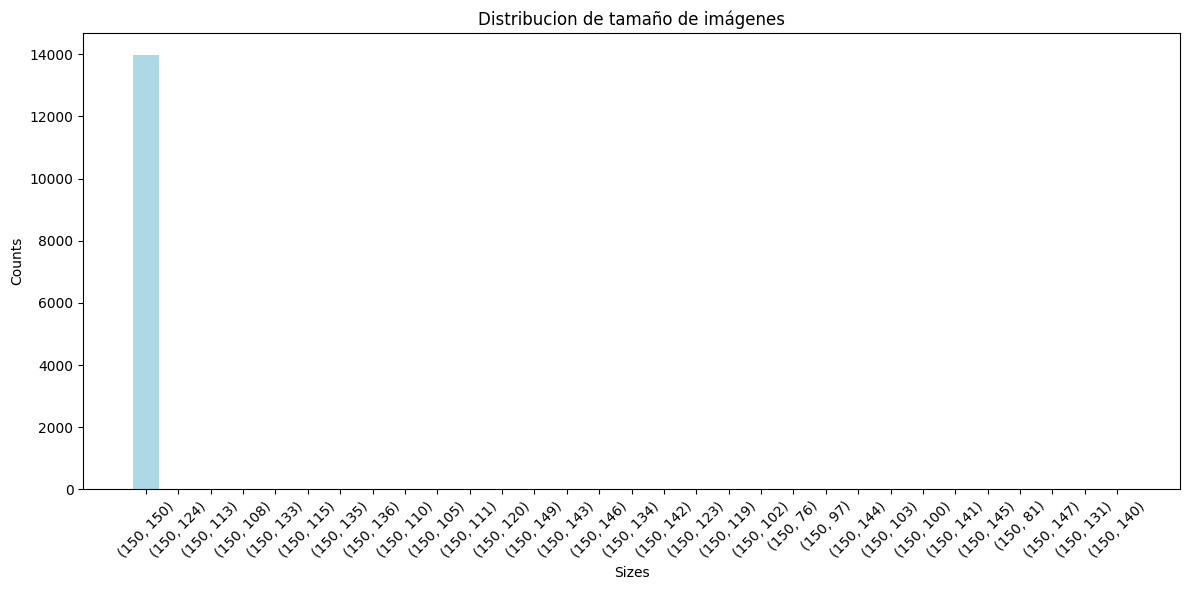

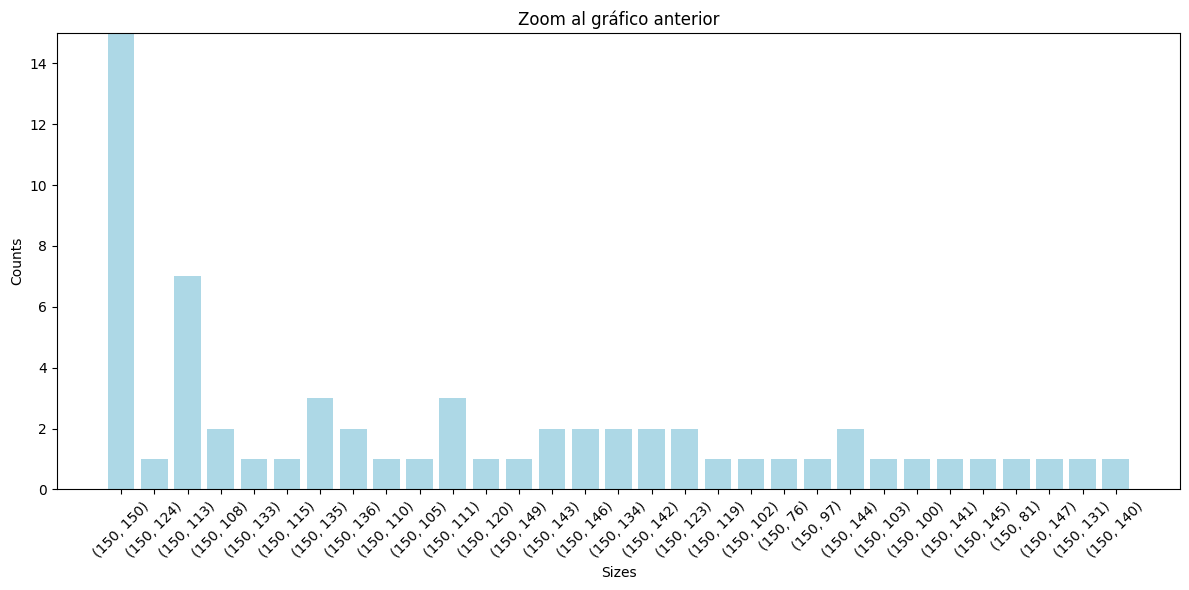

In [24]:
sizes = list(size_distribution.keys())
counts = list(size_distribution.values())

plt.figure(figsize=(12, 6))
plt.bar([str(size) for size in sizes], counts, color='lightblue')
plt.xlabel('Sizes')
plt.ylabel('Counts')
plt.title('Distribucion de tamaño de imágenes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.bar([str(size) for size in sizes], counts, color='lightblue')
plt.xlabel('Sizes')
plt.ylabel('Counts')

plt.ylim(0, 15)
plt.title('Zoom al gráfico anterior')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Estructura y tipo de las imágenes

In [25]:
def show_examples(path, num_classes=5, images_per_class=3):
    classes = random.sample(os.listdir(path), min(num_classes, len(os.listdir(path))))
    fig, axs = plt.subplots(num_classes, images_per_class, figsize=(15, 3*num_classes))
    
    for i, class_name in enumerate(classes):
        class_path = os.path.join(path, class_name)
        images = random.sample([img for img in os.listdir(class_path) if img.lower().endswith(('.jpg'))], images_per_class)
        
        for j, img_name in enumerate(images):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            if j == 0:
                axs[i, j].set_title(class_name, loc='left')
    
    plt.tight_layout()
    plt.show()

In [ ]:
image_sizes = []
image_formats = []
random_images = []

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    image_files = os.listdir(class_path)
    random_image_file = random.choice(image_files)
    random_images.append((class_name, random_image_file))  # Guardar el nombre de la imagen
    image = Image.open(os.path.join(class_path, random_image_file))
    image_sizes.append(image.size)
    image_formats.append(image.format)

for i, (class_name, image_file) in enumerate(random_images):
    print(f"Clase: {class_name}, Imagen: {image_file}, Tamaño: {image_sizes[i]}, Formato: {image_formats[i]}")

show_examples(dataset_path)

Clase: buildings, Imagen: 3142.jpg, Tamaño: (150, 150), Formato: JPEG
Clase: forest, Imagen: 14642.jpg, Tamaño: (150, 150), Formato: JPEG
Clase: glacier, Imagen: 14298.jpg, Tamaño: (150, 150), Formato: JPEG
Clase: mountain, Imagen: 8695.jpg, Tamaño: (150, 150), Formato: JPEG
Clase: sea, Imagen: 15188.jpg, Tamaño: (150, 150), Formato: JPEG
Clase: street, Imagen: 7367.jpg, Tamaño: (150, 150), Formato: JPEG


## Distribución de la variable a predecir

In [ ]:
class_counts = {}

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    # Contar el número de archivos de imagen en la carpeta
    num_images = len(os.listdir(class_path))
    class_counts[class_name] = num_images

colors = sns.color_palette('pastel', len(classes))

plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color=colors)
plt.xlabel('Class')
plt.ylabel('Images')
plt.title('Dataset train')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Modelado

## Comparativa de distintas arquitecturas de redes neuronales (ej: MLP simple y Convolucional, variando cantidad de capas, filtros, etc.).

(opcional) Prueba de técnicas avanzadas: aumentación de datos, modelos pre-entrenados, incorporación de otros conjuntos de datos similares para el entrenamiento, etc.

# 3. Conclusiones

Desarrollar las conclusiones finales a las que llegaron a partir de los experimentos, destacando la interpretación de los resultados obtenidos.